### A demo for fine-tuning with our tool

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec

In [2]:
import numpy as np
import pickle
import time
import os

import sys
sys.setrecursionlimit(1000000)

# from ConvAE_FT import ConvAE
import ConvAE
import utils

In [3]:
# load data
X_cnn_raw = []
labels_cnn_raw = []
num_grp = 3
for i in range(num_grp):
    fname = '../../LRG-fits/data/lrg_171029/sample-lrg-train-140-120-c3-gr{0}.pkl'.format(i)
    with open(fname, 'rb') as fp:
        datadict = pickle.load(fp)
        X_cnn_raw.append(datadict['data'])
        labels_cnn_raw.append(datadict['label'])
    time.sleep(3)

# Combine and normalization
sample_mat = np.vstack(X_cnn_raw)
del(X_cnn_raw)
labels_cnn = np.hstack(labels_cnn_raw)
del(labels_cnn_raw)

rs = 120
X_tr_cnn = sample_mat.reshape(-1,rs,rs,1).astype('float32')

idx = np.random.permutation(len(labels_cnn))
numsamples = 100000
X_in = X_tr_cnn[idx[0:numsamples],:,:,:]
# get labels
X_out = labels_cnn[idx[0:numsamples]].astype('int32')

mask_layer1 = [100,0,1,100,100,100,1,100]
data_layer1,label_layer1 = utils.sub2multi(data=X_in, label=X_out, mask=mask_layer1)
label_layer1_hotpot = utils.vec2onehot(label=label_layer1, numclass=2)

In [4]:
# Construct the net
numclass = 2
encode_nodes = 64
cnn = ConvAE.ConvAE(input_shape=data_layer1.shape,
                      kernel_size=[3,3,3,3,3],
                      kernel_num = [8,8,16,32,32],
                      fc_nodes=[], encode_nodes=encode_nodes,
                      padding=('SAME','SAME'),
                      stride=(2,2),
                      numclass = numclass,
                      sess = None,
                      name = None)
cnn.cae_build()
cnn.cnn_build(learning_rate=0.001) # In order to init the weights

In [5]:
# load pretrained net
foldname = "./net-pretrained/"
name = "pretrained.pkl"
cnn.sess, cnn.name = utils.load_net(os.path.join(foldname, name))

INFO:tensorflow:Restoring parameters from ./net-pretrained/model-pretrain.ckpt


In [6]:
# training
num_epochs = 50
learning_rate = 0.0005
batch_size = 100
droprate = 0.5
cnn.cnn_train(data=data_layer1, label=label_layer1_hotpot, num_epochs=num_epochs, learning_rate=learning_rate,
              batch_size=batch_size, droprate=droprate)

[2017-12-12: 19:58:46] Training parameters

[2017-12-12: 19:58:46] Epochs: 50	Learning rate: 0.00

[2017-12-12: 19:58:46] Batch size: 100	Drop rate: 0.50

[2017-12-12: 19:58:49] Epoch: 001 Trn loss: 0.678274 Trn acc: 0.570 Val loss: 0.585572 Val acc: 0.728
[2017-12-12: 19:58:51] Epoch: 002 Trn loss: 0.489413 Trn acc: 0.823 Val loss: 0.466349 Val acc: 0.844
[2017-12-12: 19:58:53] Epoch: 003 Trn loss: 0.468325 Trn acc: 0.841 Val loss: 0.463335 Val acc: 0.848
[2017-12-12: 19:58:55] Epoch: 004 Trn loss: 0.463741 Trn acc: 0.846 Val loss: 0.471561 Val acc: 0.838
[2017-12-12: 19:58:58] Epoch: 005 Trn loss: 0.459368 Trn acc: 0.851 Val loss: 0.449925 Val acc: 0.864
[2017-12-12: 19:59:00] Epoch: 006 Trn loss: 0.453617 Trn acc: 0.858 Val loss: 0.453615 Val acc: 0.858
[2017-12-12: 19:59:02] Epoch: 007 Trn loss: 0.451586 Trn acc: 0.860 Val loss: 0.453357 Val acc: 0.855
[2017-12-12: 19:59:05] Epoch: 008 Trn loss: 0.449689 Trn acc: 0.861 Val loss: 0.448163 Val acc: 0.862
[2017-12-12: 19:59:07] Epoch:

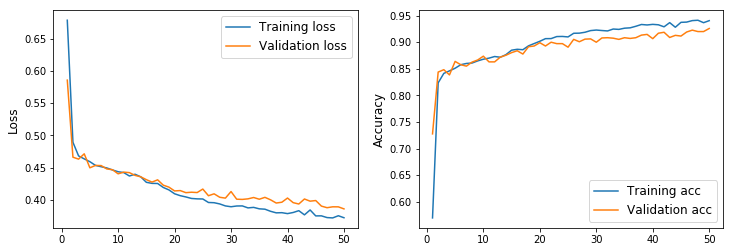

In [7]:
# Plot the curves
epochs = np.arange(1,num_epochs+1)
plt.rcParams["figure.figsize"] = [12.0, 4.0]
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax0 = plt.subplot(gs[0])
ax0.plot(epochs, cnn.cnn_trainloss)
ax0.plot(epochs, cnn.cnn_valloss)
plt.ylabel("Loss", fontsize=12)
plt.legend(["Training loss", "Validation loss"], fontsize=12)

ax1 = plt.subplot(gs[1])
ax1.plot(epochs, cnn.cnn_trainacc)
ax1.plot(epochs, cnn.cnn_valacc)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(["Training acc", "Validation acc"], fontsize=12)

In [10]:
# save loss and accuracies
foldname = "Branch3"
if os.path.exists(foldname):
    os.remove(foldname)
os.mkdir(foldname)
fname = "loss_l3.pkl"
folder= "{0}/".format(foldname)
with open(os.path.join(folder,fname), 'wb') as fp:
    loss_dict={"loss_train": cnn.cnn_trainloss,
               "loss_val": cnn.cnn_valloss,
               "acc_train": cnn.cnn_trainacc,
               "acc_val": cnn.cnn_valacc}
    pickle.dump(loss_dict, fp)

In [11]:
# save net
foldname = "{0}/net_l3".format(foldname)
name = "net_l3.pkl"
netname = "model-l3.ckpt"
if os.path.exists(foldname):
    os.system("rm -r %s" % (foldname))
os.mkdir(foldname)
cnn.cnn_save(namepath=os.path.join(foldname, name),
             netpath=os.path.join(foldname, netname))